<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Chapter_4_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 14.7MB/s 
     |████████████████████████████████| 194kB 50.2MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 1.2MB 43.9MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
(path/'train/3').ls()

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/1150.png'),Path('/root/.fastai/data/mnist_sample/train/3/1121.png'),Path('/root/.fastai/data/mnist_sample/train/3/34239.png'),Path('/root/.fastai/data/mnist_sample/train/3/34728.png'),Path('/root/.fastai/data/mnist_sample/train/3/2021.png'),Path('/root/.fastai/data/mnist_sample/train/3/33745.png'),Path('/root/.fastai/data/mnist_sample/train/3/4281.png'),Path('/root/.fastai/data/mnist_sample/train/3/59978.png'),Path('/root/.fastai/data/mnist_sample/train/3/58339.png'),Path('/root/.fastai/data/mnist_sample/train/3/49955.png')...]

In [ ]:
tensor(Image.open((path/'train/3').ls()[0]))

The "picture" above is the internal representation of an image. A series of 0s indicating white and various positive numbers indicating the intensity of black. For example we can see that the numbers at the edges of the picture tend to be smaller than the ones in the center.

We need to create some baseline model for classifying digits. One reasonable try is to use the "average" 3 or the "average" 7 and compare a new digit to those two images and calculate the distance.

In [6]:
threes = [tensor(Image.open(x)) for x in (path/'train/3').ls()]
sevens = [tensor(Image.open(x)) for x in (path/'train/7').ls()]
# Here we have a list of tensors and we need the mean of all of them. The way to do this is to stack them (create a 3 dim tensor), convert them to float tensors (mean does not work on ints) and then take the mean
threes = torch.stack(threes).float()
sevens = torch.stack(sevens).float()
# I could have simply divided the whole thing by 1.0 and Torch would have done the conversion automatically

In [7]:
average_three = torch.mean(threes, dim = 0)
average_seven = torch.mean(sevens, dim = 0)
# The dimension specified in torch.mean is the one you collapse by. Here we had tensors of size X*28*28 where X is the number of training examples. So this is the dimension we want to collapse by

In [8]:
df = pd.DataFrame(torch.trunc(average_three))
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,5.000000,6.000000,6.000000,6.000000,5.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,14.000000,23.000000,34.000000,46.000000,56.000000,62.000000,63.000000,60.000000,50.000000,38.000000,26.000000,16.000000,8.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,15.000000,28.000000,47.000000,71.000000,97.000000,122.000000,142.000000,156.000000,158.000000,152.000000,134.000000,107.000000,77.000000,51.000000,29.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,1.000000,6.000000,15.000000,30.000000,52.000000,81.000000,111.000000,138.000000,160.000000,174.000000,184.000000,189.000000,189.000000,179.000000,155.000000,122.000000,86.000000,54.000000,27.000000,9.000000,2.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,2.000000,9.000000,21.000000,39.000000,61.000000,86.000000,108.000000,125.000000,134.000000,138.000000,142.000000,149.000000,160.000000,166.000000,158.000000,134.000000,103.000000,68.000000,36.000000,13.000000,2.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,3.000000,10.000000,20.000000,34.000000,49.000000,63.000000,75.000000,80.000000,80.000000,79.000000,82.000000,93.000000,115.000000,137.000000,145.000000,134.000000,106.000000,70.000000,37.000000,14.000000,2.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,2.000000,7.000000,14.000000,22.000000,30.000000,36.000000,39.000000,41.000000,41.000000,43.000000,52.000000,74.000000,106.000000,135.000000,146.000000,131.000000,99.000000,62.000000,30.000000,11.000000,2.000000,0.000000,0.000000,0.000000,0.000000


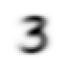

In [17]:
show_image(average_three)

In [9]:
def dist_func(t1, bench):
  return(((t1 - bench)**2).mean())

In [10]:
def my_classifier(x):
  if dist_func(x, average_three) < dist_func(x, average_seven):
    return(3)
  else:
    return(7)

In [11]:
dist_func(threes[0], average_three)
F.mse_loss(threes[0], average_three)

tensor(3050.8406)

In [12]:
from collections import Counter
print(Counter([my_classifier(x) for x in threes]))
print(Counter([my_classifier(x) for x in sevens]))

Counter({3: 5848, 7: 283})
Counter({7: 6159, 3: 106})


In [13]:
threes_test = torch.stack([tensor(Image.open(x)) for x in (path/'valid/3').ls()])/1.0
sevens_test = torch.stack([tensor(Image.open(x)) for x in (path/'valid/7').ls()])/1.0

The problem with the way that I have defined the functions is that they do not work in a vectorised manner. So I have to use the pre-stacked lists in order to calculate it in an elementwise manner. I have to redo them

In [14]:
def vect_dist(ten, bench):
    return(((ten - bench)**2).mean((-1,-2)))

In [15]:
def vect_class(ten):
    return(torch.where(vect_dist(ten, average_seven) > vect_dist(ten, average_three), 3, 7))

In [16]:
correct_threes = (vect_class(threes_test) == 3).sum()
correct_sevens = (vect_class(sevens_test) == 7).sum()
accuracy = (correct_sevens + correct_threes) / (len(threes_test) + len(sevens_test))

In [67]:
accuracy

tensor(0.9661)

Working with gradients in PyTorch

In [18]:
x = tensor([3.0, 5, 7]).requires_grad_()

In [22]:
def my_fun(ten):
    return((2*ten**2).sum())

In [25]:
y = my_fun(x)
y.backward()
x.grad

tensor([12., 20., 28.])

In [64]:
x = tensor([3.0, 5, 7]).requires_grad_()
y = tensor([2.0, 1, 1]).requires_grad_()
z = (x*y).sum()
z.backward()
x.grad

tensor([2., 1., 1.])

The way the gradient is calculated for this example is the following:  
The function that we have at hand is 2*x^2 + 2*y^2 + 2*z^2 and the moment we calculate the gradient we get 4*x, 4*y, 4*z

Let's create a practical example for this. The function that I want to simulate is 2*(x-5)^3 - 10*x^2 - x

In [39]:
time = torch.arange(20).float()
values = torch.randn(20)*2 + 2*(time-5)**3 - 10*time**2 - time

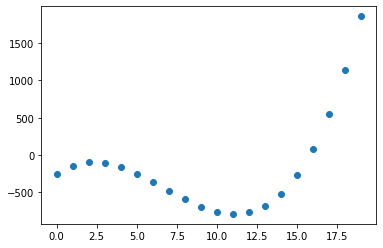

In [40]:
plt.scatter(time, values)

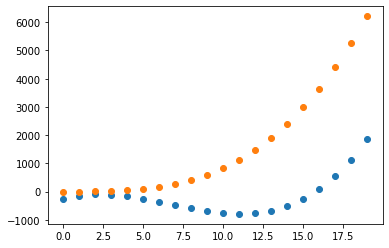

In [54]:
def f(t, params):
    a, b, c, d = params
    return(a*(t-b)**3+c*t**2+d*t)

#params = torch.randn(4).requires_grad_()
params = tensor([1., 1., 1., 1.]).requires_grad_()
my_preds = f(time, params)

plt.scatter(time, values)
plt.scatter(time, to_np(my_preds))

Clearly this is not working great, but we can use the gradients to adjust the parameters.

In [55]:
loss = mse(my_preds, values)
loss.backward()

In [56]:
params.grad

tensor([10059390.0000, -2000343.2500,   762932.5000,    49835.7578])

How are these values for the gradient calculated? Let's follow the gradient steps for the parameter a. What we need to do is calculate the gradient of the loss with respect to a
Loss = (a*(x-b)^3+c*x^2+d*x - actual_values)^2
Loss derivative would be: 2*(a*(x-b)^3+c*x^2+d*x - actual_values)*(x-b)^3

In [66]:
(2*(my_preds - values)*(time-1)**3).sum()

tensor(2.0119e+08, grad_fn=<SumBackward0>)